In [1]:
!pip install xgboost
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=6e4d3057e41c3165d8e4bb54e9784111786711a6394fd42a786f34d6c4b615f2
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd '/content/drive/My Drive/545'

/content/drive/.shortcut-targets-by-id/1J_PriDjeXBMe5ZgB5xWSbk3VidGot_gP/545


In [5]:
df = pd.read_csv(r'Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [6]:
df.shape

(10000, 14)

In [7]:
#Getting the independent features
X = df.iloc[:,3:-1]
#Getting the dependent feature
y = df.iloc[:,-1]

In [8]:
#Dummy variable for 'Geography' column
geography = pd.get_dummies(X['Geography'], drop_first = True)
#Dummy variable for 'Gender' column
gender = pd.get_dummies(X['Gender'], drop_first = True)

#Dropping the original 'Geography' and 'Gender' columns
X = X.drop(['Geography','Gender'], axis = 1)

#Adding the dummy columns to the dataset
X = pd.concat([X,geography,gender], axis = 1)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,1,0


In [9]:
## Hyperparameter optimization using Bayesian Optimization

import xgboost as xgb
from scipy.stats import loguniform
import numpy as np
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt


In [10]:
global_parms = {"booster"         : "gbtree", 
                "missing"         : None,
                "n_estimators"    : 100, 
                "n_jobs"          : 1, 
                "objective"       : 'binary:logistic', 
                "random_state"    : 545, 
                "scale_pos_weight": 1, 
                "verbosity"       : 1,
                "eval_metric"     : 'logloss'
}

In [11]:
params_space={
 "base_score"       : (0.1,0.9),
 "colsample_bylevel": (0.1,1),
 "colsample_bynode" : (0.1,1),
 "colsample_bytree" : (0.1,1),
 "learning_rate"    : (1e-6, 1),
 "max_delta_step"   : (0, 10), # integer
 "max_depth"        : (1, 20), # integer
 "min_child_weight" : (1, 20),
 "gamma"            : (0.1,10),
 "subsample"        : (0.1,1),
 "reg_lambda"       : (1, 9),
 "reg_alpha"        : (1, 9),
}

In [16]:
def bo_tune_xgb(base_score, colsample_bylevel,colsample_bynode,colsample_bytree,learning_rate,max_delta_step,max_depth,min_child_weight,gamma,subsample,reg_lambda,reg_alpha):
      xgb_params = {
              'base_score': base_score,
              'colsample_bylevel':colsample_bylevel,
              'colsample_bytree':colsample_bytree,
              'colsample_bynode':colsample_bynode,
              'learning_rate': learning_rate,
              'subsample': subsample,
              'gamma': gamma,
              'min_child_weight': min_child_weight,
              'max_depth': int(max_depth),
              'max_delta_step':int(max_delta_step),
              'reg_alpha': reg_alpha,
              'reg_lambda': reg_lambda,
              }   
      param_all = global_parms.copy()
      param_all.update(xgb_params)
      cv_result = xgb.cv(param_all, dtrain, num_boost_round= 100, nfold=3)
      return -1.0 * cv_result['test-logloss-mean'].iloc[-1]

In [17]:
def run_xgb(params, X_train, y_train, fold = 10):
  param_all = global_parms.copy()
  param_all.update(params)
  dtrain = xgb.DMatrix(X_train, label = y_train)
  cv_result =  xgb.cv(param_all, dtrain, num_boost_round = 70, nfold=fold)
  return cv_result['test-logloss-mean'].iloc[-1]

In [20]:

dtrain = xgb.DMatrix(X, label = y)
xgb_bo = BayesianOptimization(bo_tune_xgb, params_space, random_state=545)
xgb_bo.maximize(init_points=10, n_iter=20,acq='ucb')


best_params = xgb_bo.max['params']
print(best_params)# best params
best_params['max_depth'] = int(best_params['max_depth'])
best_params['max_delta_step'] = int(best_params['max_delta_step'])

|   iter    |  target   | base_s... | colsam... | colsam... | colsam... |   gamma   | learni... | max_de... | max_depth | min_ch... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.3553   |  0.169    |  1.0      |  0.1593   |  0.2364   |  4.2      |  0.196    |  7.46     |  7.755    |  17.99    |  6.475    |  6.452    |  0.853    |
|  2        | -0.3518   |  0.5418   |  0.5417   |  0.9914   |  0.2887   |  0.505    |  0.7791   |  9.554    |  8.806    |  3.901    |  2.858    |  7.247    |  0.7661   |
|  3        | -0.3476   |  0.6261   |  0.8039   |  0.9993   |  0.519    |  8.642    |  0.3558   |  2.896    |  10.43    |  19.47    |  7.675    |  7.034    |  0.5463   |
|  4        | -0.3476   |  0.8713   |  0.146    |  0.9755   |  0.6991   |  2.827    |  0.3138   |  1.065    |  9.985    |  17.44    |  7.657    |  5.1

In [21]:
run_xgb(best_params, X, y)

0.3372487

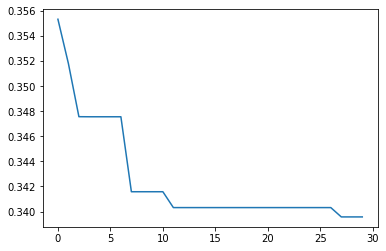

In [24]:
bo_val_loss = []
for i,res in enumerate(xgb_bo.res):
    bo_val_loss.append(-1.0 * xgb_bo.res[i]['target'])    

loss = np.array(bo_val_loss)
np.minimum.accumulate(loss)
plt.figure()
plt.plot(np.minimum.accumulate(loss))